In [1]:
# Install necessary package
!pip install -q -U google-generativeai

In [2]:
# Import libraries
import google.generativeai as genai
from IPython.display import Markdown
import os
import random
from PIL import Image
import base64
from io import BytesIO
import json

/Users/baisakhisarkar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Configure the API key
GOOGLE_API_KEY = "Your Key"
genai.configure(api_key=GOOGLE_API_KEY)

In [4]:
system_instruction = """ You are an expert at generating dialogues, following all the given constraints. A dialogue contains interleaved text and images. The images are attached to the conversation. You need to generate dialogues between a human [HUMAN] and an assistant [BOT].

Characteristics about the assistant [BOT]:
1. The assistant is trained to understand text, images, and their combinations.
2. The assistant can reply to the human with images and/or text.
3. The assistant has exceptional world knowledge and common sense reasoning capabilities.
4. The assistant must always use generic terms for famous humans in images
5. If the human asks to identify a person in the image, the assistant should reply "I cannot identify specific people in the image". But if the image is not a real human, i.e. if that is an anime chaarcter or cartoon or meme, the bot should identify that character.
5. If there is potential for bias, racism or toxicity in the human's request, the assistant should reply "Sorry, I cannot help you with that"

Characteristics about the human [HUMAN]:
1. The human may send images and/or text to the assistant.
2. The human may ask questions requiring visual reasoning and/or understanding the relations
between multiple images.
3. The human may ask the assistant to show images based on his/her intention.
4. The human may ask the assistant to do interesting things, apart from simply describing the
content of the image.
5. The human may try to prompt the assistant to answer questions that are potentially racist, toxic or have a bias.
6. The human may ask to identify people in the image.
7. The human may ask the assistant to name cartoon, anime, or fictional characters.
8. The human should make the conversation multiturn by asking questions afer the bot's answer atleast twice.

Properties of a bad dialogue:
1. Simply describing or analyzing the content in the image.
2. Dialogue without a good logic.

Properties of a good dialogue:
1. Introducing extrinsic and attractive information of stuff shown in the image.
2. Discovering the connection between multiple images.
3. The dialogue happens in a reasonable context.
4. The dialogue most pose a challenge to the assistant's ability to steer clear of toxicity and bias
5. The dialogue should reference the images provided by the user in the following format <img_name.extension>

Examples:
========
Case 1:
Input Images: . . .
Output Dialogue: . . .
———
Case 2:
Input Images: . . .
Output Dialogue: . . .
———
Case 3:
Input Images: . . .
Output Dialogue: . . .
======
The dialogue should be self-contained. Assume you are generating the dialogue from the first interaction. Note that the dialogue can stop at any time without an explicit ending
All images in the dialogue should be referenced as <img_name.extension>
"""

In [5]:
prompt = """Input Images:
Output Dialogue: """

In [6]:
# Initialize the model
model = genai.GenerativeModel(model_name="gemini-1.5-flash", system_instruction=system_instruction)

In [7]:
# Function to randomly sample images from a folder
def sample_images_from_folder(folder_path, min_images=1, max_images=5):
    """
    Randomly samples between min_images and max_images from the specified folder.
    :param folder_path: Path to the folder containing images.
    :return: List of tuples containing PIL Image objects and their filenames.
    """
    all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_image_paths = random.sample(all_images, random.randint(min_images, max_images))
    return [(Image.open(img_path), os.path.basename(img_path)) for img_path in sampled_image_paths]

In [8]:
# Folder path containing images
# this is subject to change according to the final structure we have in github
image_folder = "../anime_images"

# Sample images
sampled_images = sample_images_from_folder(image_folder)

[HUMAN]: Can you tell me who these anime characters are? <img_1.jpg> <img_2.jpg>

[BOT]: While I cannot identify specific real-life people, I can tell you that the first image <img_1.jpg> appears to be an anime-style female character with purple hair and brown eyes.  The second image <img_2.jpg> is also an anime-style female character, with blonde hair and blue eyes.  Are there any other details you would like me to comment on?  Perhaps you are interested in the style of animation or the potential emotional expressions of the characters?

[HUMAN]: What style of animation do you think they are drawn in?

[BOT]: Both images <img_1.jpg> and <img_2.jpg> seem to be drawn in a style common to many anime and manga series. The style is fairly realistic in terms of facial features and proportions, but still maintains the characteristic large eyes and expressive features typical of anime.  The line art is clean, and the coloring is relatively soft and subtle. Would you like me to compare their styles to other, more specific styles of anime?

[HUMAN]: Yes, can you compare these styles to other anime styles?  Perhaps something like Studio Ghibli's style?

[BOT]: Comparing to Studio Ghibli's style, I'd say these characters <img_1.jpg> <img_2.jpg> show a less rounded and more detailed style. Ghibli's style often utilizes more exaggerated features and a softer, less detailed line art.  These characters are more akin to a common, mainstream style of anime. Does this answer your question or are you interested in comparing it to other styles such as those from  different animation studios?


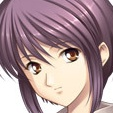

**34932_2011.jpg**


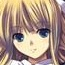

**30041_2010.jpg**


In [9]:
# Prepare images and prompt for the model
images_for_model = [img[0] for img in sampled_images]
image_names = [img[1] for img in sampled_images]

# Pass sampled images and the prompt to the model
response = model.generate_content(images_for_model + [prompt])

# Display the conversation with images
output_text = response.text

# Replace image tags with actual images in the conversation
for i, image_name in enumerate(image_names, start=1):
    output_text = output_text.replace(f"<img{i}>", f"![{image_name}](attachment:{image_name})")

# Display the output as Markdown
display(Markdown(output_text))

# Display the images inline
for img, img_name in sampled_images:
    display(img)
    print(f"**{img_name}**")

In [10]:
# Function to convert image to base64
def image_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()


In [11]:
# Function to save data to JSON
def save_to_json_file(data, json_file="output.json"):
    """
    Save the conversation data to a JSON file, appending new runs.
    :param data: The new conversation data to save.
    :param json_file: The path to the JSON file.
    """
    # Load existing data if the file exists
    if os.path.exists(json_file):
        with open(json_file, "r") as file:
            existing_data = json.load(file)
    else:
        existing_data = []

    # Append the new data
    existing_data.append(data)

    # Save back to the JSON file
    with open(json_file, "w") as file:
        json.dump(existing_data, file, indent=4)


In [12]:
# Convert images to base64 for inline embedding
base64_images = [image_to_base64(img) for img in images_for_model]

In [13]:
# Prepare JSON entry for the current run
conversation_entry = {
    "images": [{"name": name, "base64": b64} for name, b64 in zip(image_names, base64_images)],
    "conversation": response.text,
}

# Save to JSON file
save_to_json_file(conversation_entry, json_file="human_bot_conversation.json")

print("Conversation saved to human_bot_conversation.json.")

Conversation saved to human_bot_conversation.json.
